In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import auc, roc_curve

In [2]:
class LogisticRegression(object):
    def __init__(self, X_train, y_train, X_test, y_test, learn_rate=0.001, n_iters=500):
        if len(X_train.shape) == 1:
            self.X_train = np.hstack((np.array([1]), X_train))
        else:
            self.X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
        self.y_train = y_train
        
        if len(X_test.shape) == 1:
            self.X_test = np.hstack((np.array([1]), X_test))
        else:
            self.X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
        self.y_test = y_test
        
        self.learn_rate = learn_rate
        self.n_iters = n_iters 

        # Initialize model weights
        self.weight = np.zeros((self.X_train.shape[1]))

        self.accuracy_train = []  # To keep track of accuracy on the training data during gradient ascent process
        self.accuracy_test = []  # To keep track of accuracy on the test data during gradient ascent process

        self.log_likelihood_train = []  # To keep track of average log likelihood on the training data during gradient ascent process
        self.log_likelihood_test = []  # To keep track of average log likelihood on the test data during gradient ascent process

    def predict(self, samples, threshold=0.5):
        return self.predict_prob(samples) >= threshold

    def predict_prob(self, samples):
        """ Compute and return predicted probability of each sample having income >= 50K"""
        
        # Ensure samples have intercept
        if samples.shape[1] == self.weight.shape[0] - 1:
            samples = np.hstack([np.ones((samples.shape[0], 1)), samples])
            
        # Dot product
        linear_combination = np.dot(samples, self.weight)
        
        # Apply sigmoid
        prob = 1 / (1 + np.exp(-linear_combination))
        
        return prob



    def compute_gradient(self):
        """ Compute and return gradient of the average log-likelihood objective. """
        linear_combination = np.dot(self.X_train, self.weight)
        prob = 1 / (1 + np.exp(-linear_combination))
        
        # calc gradient
        gradient = np.dot(self.X_train.T, (self.y_train - prob)) / self.X_train.shape[0]
        
        return gradient
    
    def gradient_ascent(self):
        """ Optimize model weights using gradient ascent. """
        for i in range(self.n_iters):
            # calc gradient
            gradient = self.compute_gradient()
            
            # update weights
            self.weight += self.learn_rate * gradient
            
            # Compute/store log likelihoods
            self.log_likelihood_train.append(self.compute_log_likelihood(self.X_train, self.y_train))
            self.log_likelihood_test.append(self.compute_log_likelihood(self.X_test, self.y_test))
            
            # Compute and store prediction accuracies
            self.accuracy_train.append(self.compute_accuracy(self.X_train, self.y_train))
            self.accuracy_test.append(self.compute_accuracy(self.X_test, self.y_test))
    
            
    def compute_log_likelihood(self, X, y):
        # Compute predicted probs
        linear_combination = np.dot(X, self.weight)
        prob = 1 / (1 + np.exp(-linear_combination))
        
        # Compute log likelihood
        log_likelihood = np.sum(y * np.log(prob) + (1 - y) * np.log(1 - prob))
        
        return log_likelihood / len(y)
    
    def compute_accuracy(self, X, y):
        # Predict labels
        predictions = self.predict(X)
        
        # Compute accuracy
        return np.mean(predictions == y)
        

In [3]:
def preprocess_data(X_train, X_test):
    # ID categorical and numerical columns
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
    numerical_cols=X_train.select_dtypes(include=['number']).columns
    
    # Create a column transformer with OneHotEncoder and StandardScaler
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])
    
    # Fit and transform data
    X_train_transformed = preprocessor.fit_transform(X_train)
    # Transform test data
    X_test_transformed = preprocessor.transform(X_test)

    if sparse.issparse(X_train_transformed):
        X_train_transformed = X_train_transformed.toarray()
    if sparse.issparse(X_test_transformed):
        X_test_transformed = X_test_transformed.toarray()

    return X_train_transformed, X_test_transformed

In [4]:
def plot_log_likelihood_performance(log_likelihood_train, log_likelihood_test):
    # Create fig
    plt.figure(figsize=(10, 6))
    
    # Plot log likelihood
    plt.plot(log_likelihood_train, label='Train Log Likelihood', color='blue')
    
    # Plot log likelihood for test set
    plt.plot(log_likelihood_test, label='Test Log Likelihood', color='red')
    
    # Add labels and title
    plt.xlabel('Iterations')
    plt.ylabel('Average Log Likelihood')
    plt.title('Log Likelihood during Gradient Ascent')
    
    # Add legend
    plt.legend()
    
    # Show the plot
    plt.show()

In [5]:
def plot_accuracy_performance(accuracy_train, accuracy_test):
    # Create a fig
    plt.figure(figsize=(10, 6))
    
    # Plot the accuracy for the training set
    plt.plot(accuracy_train, label='Training Accuracy', color='blue')
    
    # Plot the accuracy for test set
    plt.plot(accuracy_test, label='Test Accuracy', color='red')
    
    # Add labels, title
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Accuracy during Gradient Ascent')
    
    # Legend
    plt.legend()
    
    # Show
    plt.show()

In [6]:
def plot_roc(X_train, y_train, X_test, y_test, learner):
    # Calc probs of the positive class
    probs_train = learner.predict_prob(X_train)
    probs_test = learner.predict_prob(X_test)
    
    # Compute ROC curve and area underneath for training
    fpr_train, tpr_train, _ = roc_curve(y_train, probs_train)
    roc_auc_train = auc(fpr_train, tpr_train)

    # Compute ROC curve and area underneath for testing
    fpr_test, tpr_test, _ = roc_curve(y_test, probs_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC Curve (area = {roc_auc_train:.2f})')
    plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC Curve (area = {roc_auc_test: .2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

In [7]:
# Load data
train_data = pd.read_csv('cleaned_train_data.csv')
test_data = pd.read_csv('cleaned_test_data.csv')
X_train = train_data.drop(['income'], axis=1, inplace=False)
y_train = train_data['income']
X_test = test_data.drop(['income'], axis=1, inplace=False)
y_test = test_data['income']

In [8]:
# Preprocessing data
processed_X_train, processed_X_test = preprocess_data(X_train, X_test)

In [9]:
# Run gradient ascent with Logistic Regression
learner = LogisticRegression(processed_X_train, y_train.values, processed_X_test, y_test.values,
                               n_iters=250, learn_rate=0.75)
learner.gradient_ascent()

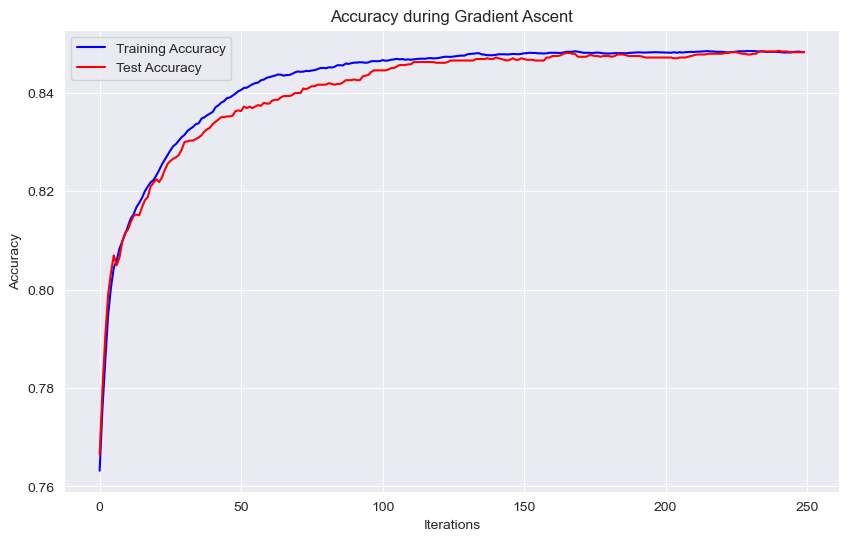

In [10]:
# Plot prediction accuracy during training process
plot_accuracy_performance(learner.accuracy_train, learner.accuracy_test)

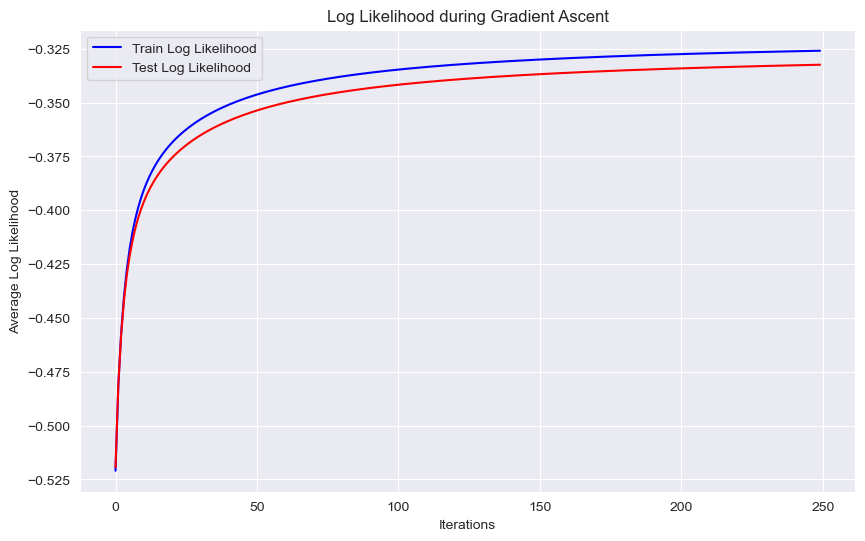

In [11]:
# Plot Log Likelihood values during training process
plot_log_likelihood_performance(learner.log_likelihood_train, learner.log_likelihood_test)

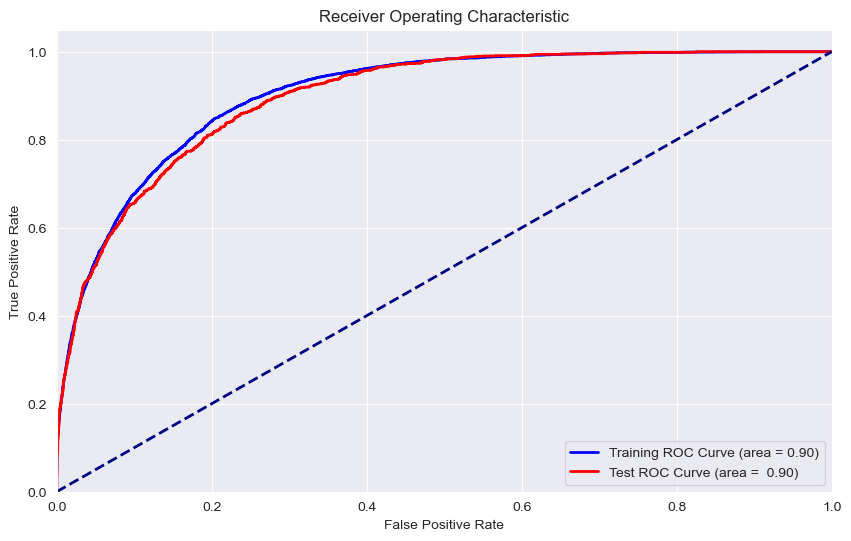

In [12]:
# Plot ROC curves
plot_roc(processed_X_train, y_train, processed_X_test, y_test, learner)